In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import torch
import matplotlib.pyplot as plt
from src import models, data
from tqdm.auto import tqdm
import json
import os
import numpy as np
import copy

## Layer Sweep

In [105]:
def plot_faithfulness_results(
        results, x_tick_step=2, x_tick_rotation=0,
        truncate_keys=False
    ): 
    for bias_scale_factor in results.keys():
        results[bias_scale_factor] = np.array(results[bias_scale_factor])

    recall_upto = 3
    linewidth = 3
    alpha = 0.2
    for recall_at in range(recall_upto):
        mean = np.array([
            results[tick][:, recall_at].mean()
            for tick in results.keys()
        ])
        low = np.array([
            results[tick][:, recall_at].min()
            for tick in results.keys()
        ])
        high = np.array([
            results[tick][:, recall_at].max()
            for tick in results.keys()
        ])

        plt.plot(mean, linewidth=linewidth, label=f"recall@{recall_at + 1}")
        plt.fill_between(
            range(len(mean)),
            low,    # lower bound
            high,   # upper bound
            alpha=alpha
        )
        linewidth /= 2
        alpha /= 2
    
    plt.xticks(
        range(0, len(results.keys()), x_tick_step), 
        [
            layer_name.split(".")[-1] if truncate_keys else layer_name
            for layer_name in list(results.keys())
        ][::x_tick_step],
        rotation = x_tick_rotation
    )
    plt.ylabel("faithfulness")
    plt.legend()
    
    return plt

In [106]:
def plot_faithfulness_results_individual_rays(
        results, recall_at = 0,
        linewidth = 3, alpha = 0.2,
        x_tick_step=2, x_tick_rotation=90,
        truncate_keys = False    
    ):
    shape_0 = -1 
    for bias_scale_factor in results.keys():
        results[bias_scale_factor] = np.array(results[bias_scale_factor])
        shape_0 = results[bias_scale_factor].shape[0] if shape_0 == -1 else shape_0

    layerwise_results = []
    for r in range(shape_0):
        r_result = np.array([
            results[bias_scale_factor][r, recall_at]
            for bias_scale_factor in results.keys()
        ])
        r_result = r_result
        plt.plot(
            r_result,
            alpha=alpha
        )
        layerwise_results.append(r_result)

    layerwise_results = np.array(layerwise_results)
    plt.plot(layerwise_results.mean(axis = 0), linewidth=linewidth, color="darkblue")

    plt.xticks(
        range(0, len(results.keys()), x_tick_step), 
        [
            layer_name.split(".")[-1] if truncate_keys else layer_name
            for layer_name in list(results.keys())
        ][::x_tick_step],
        rotation = x_tick_rotation
    )
    # plt.xlabel("Layer")
    plt.ylabel("faithfulness")
    
    return plt

In [107]:
def plot_causality_results(
        results, x_tick_step=2, x_tick_rotation=0,
        truncate_keys=False, variant = "",
    ): 
    linewidth = 3
    alpha = 0.2
    mean = []
    std = []
    for tick in results.keys():
        mean.append(np.array([
            r['efficacy_mean'] for r in results[tick]
        ]).mean())
        std.append(np.array([
            r['efficacy_std'] for r in results[tick]
        ]).mean())

    mean = np.array(mean)
    std = np.array(std)
    plt.plot(mean, linewidth=linewidth)
    plt.fill_between(
        range(len(mean)),
        mean - std,    # lower bound
        mean + std,   # upper bound
        alpha=alpha
    )
    
    plt.xticks(
        range(0, len(results.keys()), x_tick_step), 
        [
            layer_name.split(".")[-1] if truncate_keys else layer_name
            for layer_name in list(results.keys())
        ][::x_tick_step],
        rotation = x_tick_rotation
    )
    # plt.xlabel("Layer")
    plt.ylabel(f"causality <{variant}>")
    plt.legend()
    
    return plt

In [108]:
def scrape_results(path, bench_key = "faithfulness", bench_subkey = "recall_lre_if_lm_correct"):
    results = {}
    xticks = None
    for relation_name in os.listdir(path):
        print("relation_name:", relation_name)
        with open(f"{path}/{relation_name}") as f:
            sweep_results = json.load(f)
            if(bench_key in sweep_results.keys()):
                sweep_results = sweep_results[bench_key]
            else:
                sweep_results = {
                    key: sweep_results[key][bench_key] for key in sweep_results.keys() if key != "layer_n"
                }
            if xticks is None:
                xticks = [k for k in list(sweep_results.keys()) if len(sweep_results[k]) != 0]
                results = {bias_scale_factor: [] for bias_scale_factor in xticks}

            for tick in xticks:
                results[tick].append(
                    sweep_results[tick][bench_subkey]
                ) 

    return results

In [109]:
dct = {}
len(dct), dct is None

(0, False)

In [119]:
model_name = "llama-13b"
path_root = f"../results_updated/rank_sweep/{model_name}"
os.listdir(path_root)

['work location.json',
 'name religion.json',
 'task done by person NEEDS REVISION.json',
 'name gender.json']

relation_name: work location.json
relation_name: name religion.json
relation_name: task done by person NEEDS REVISION.json
relation_name: name gender.json


<module 'matplotlib.pyplot' from '/home/local_arnab/miniconda3/envs/relations/lib/python3.10/site-packages/matplotlib/pyplot.py'>

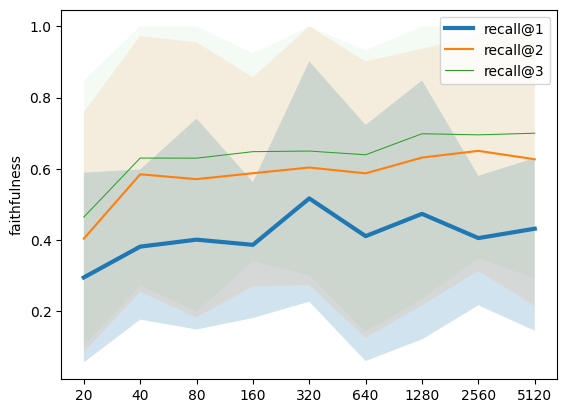

In [120]:
faithfulness_results = scrape_results(path_root)
plot_faithfulness_results(
    faithfulness_results, 
    x_tick_step=1, x_tick_rotation=0, 
    # truncate_keys=True
)
# plot_faithfulness_results_individual_rays(faithfulness_results, x_tick_step=2, x_tick_rotation=0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


relation_name: work location.json
relation_name: name religion.json
relation_name: task done by person NEEDS REVISION.json
relation_name: name gender.json


<module 'matplotlib.pyplot' from '/home/local_arnab/miniconda3/envs/relations/lib/python3.10/site-packages/matplotlib/pyplot.py'>

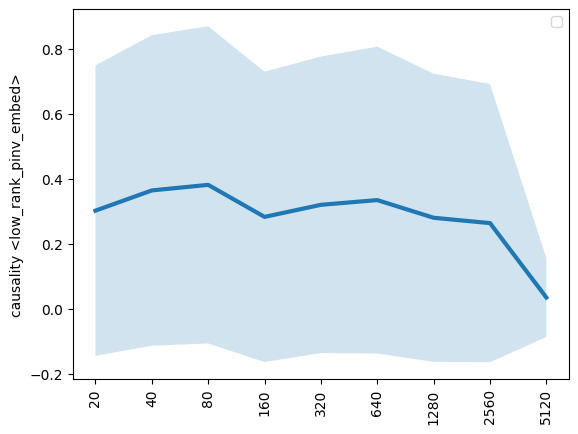

In [121]:
causality_variant = "low_rank_pinv_embed"

causality_results = scrape_results(
    path_root, 
    bench_key="causality", 
    bench_subkey=causality_variant
)

plot_causality_results(
    causality_results, 
    x_tick_step=1, x_tick_rotation=90, 
    # truncate_keys=True, 
    variant = causality_variant
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


relation_name: work location.json
relation_name: name religion.json
relation_name: task done by person NEEDS REVISION.json
relation_name: name gender.json


<module 'matplotlib.pyplot' from '/home/local_arnab/miniconda3/envs/relations/lib/python3.10/site-packages/matplotlib/pyplot.py'>

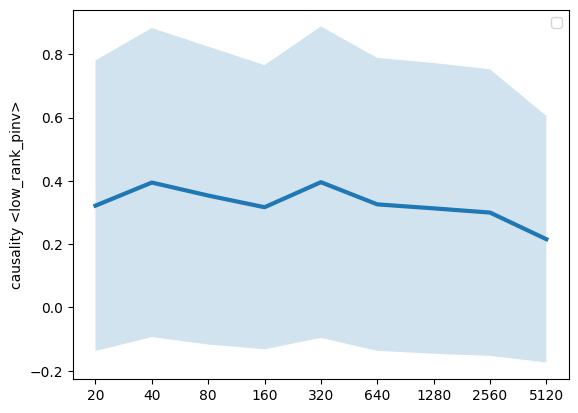

In [122]:
causality_variant = "low_rank_pinv"

causality_results = scrape_results(
    path_root, 
    bench_key="causality", 
    # bench_subkey="low_rank_pinv"
    bench_subkey=causality_variant
)

plot_causality_results(
    causality_results, 
    x_tick_rotation=0, x_tick_step=1,
    # truncate_keys=True, 
    variant = causality_variant
)